<a href="https://colab.research.google.com/github/hubertrykala93/eye-diseases-image-classification/blob/main/eye_diseases_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [23]:
import os
from math import floor
from typing import Union, List
import numpy as np
import matplotlib.pyplot as plt

from keras_preprocessing.image import load_img, img_to_array

In [2]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.style.use(style='fivethirtyeight')

# Collecting Data and Remove Unnecessary Files

In [3]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download --force -d gunavenkatdoddi/eye-diseases-classification

Saving kaggle.json to kaggle.json
 97% 717M/736M [00:03<00:00, 260MB/s]
100% 736M/736M [00:03<00:00, 242MB/s]


In [4]:
!unzip -q eye-diseases-classification.zip
!rm rf eye-diseases-classification.zip

rm: cannot remove 'rf': No such file or directory


In [5]:
os.rename(src='/content/dataset', dst='/content/files')

# Images Exploration

In [6]:
BASE_DIR = '/content/files'
DATASET_DIR = '/content/dataset'

if not os.path.exists(DATASET_DIR):
  os.mkdir(path=DATASET_DIR)

In [7]:
def show_images(kind: str, id: int = 0, random_choice: bool = False,
                make_subplots: bool = False) -> None:
    """
    Show image from file directories.

    Parameters:
    ----------
    kind: str
      Must be in 'cataract', 'diabetic_retinopathy', 'glaucoma' or normal'.

    id: int
      Index of image, while index will be higher the length of files in directory
      then will raise error.

    random_choice: bool
      If random_choice is True, function choose random image and return it.

    make_subplots: bool
      If make_subplots is True, function choose 12 random images
      and return subplots from this images.

    Returns:
    -------
    matplotlib.pyplot.Axes
    """

    filenames = dict(enumerate(os.listdir(path=os.path.join(BASE_DIR, kind))))

    if id >= len(filenames):
        raise KeyError(f'Wrong index, maximum index is {len(filenames)}.')
    else:
        if not make_subplots:
            if random_choice == False:
                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[id]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[id])
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

            else:
                random_id = filenames[np.random.choice(a=len(filenames))]

                img = load_img(path=os.path.join(BASE_DIR, kind, random_id), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=random_id)
                plt.axis('off')
                plt.grid(visible=False)

                plt.show()

        else:
            indexes = []

            while len(indexes) != 12:
                indexes = list(indexes)
                indexes.append(np.random.choice(a=len(filenames)))

                indexes = set(indexes)

            indexes = list(indexes)

            for i, index in enumerate(indexes):
                plt.subplot(4, 3, i + 1)

                img = load_img(path=os.path.join(BASE_DIR, kind, filenames[index]), target_size=(150, 150))
                X = img_to_array(img=img).astype(dtype=np.uint8)

                plt.imshow(X=X, cmap='gray_r', vmin=0, vmax=255)
                plt.title(label=filenames[index], fontdict={
                    'size': 10
                })
                plt.axis('off')
                plt.grid(visible=False)

            plt.show()

Cataract

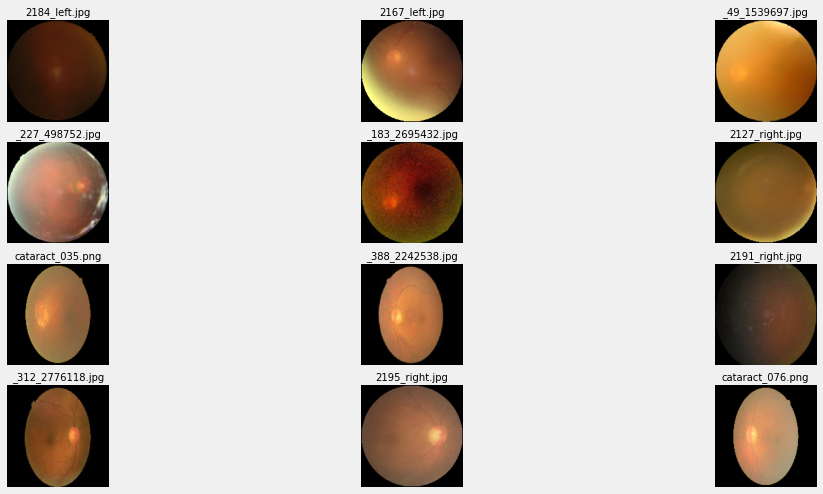

In [8]:
show_images(kind='cataract', id=990, random_choice=False, make_subplots=True)

Diabetic Retinopathy

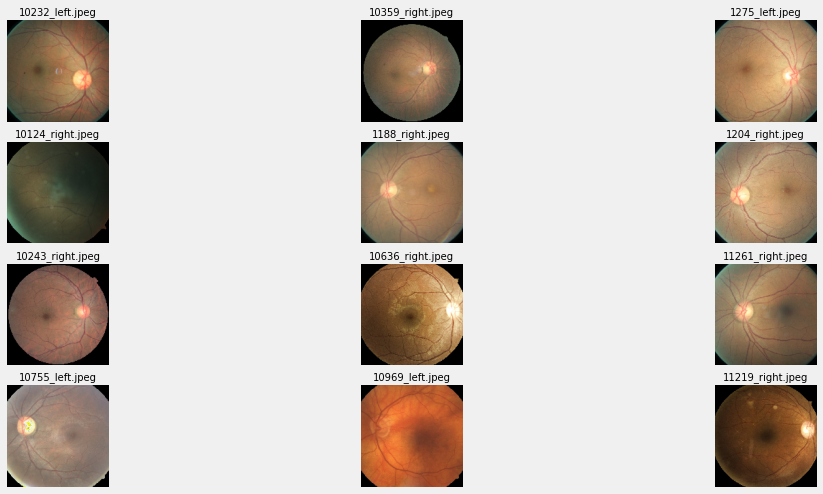

In [9]:
show_images(kind='diabetic_retinopathy', id=990, random_choice=False, make_subplots=True)

Glaucoma

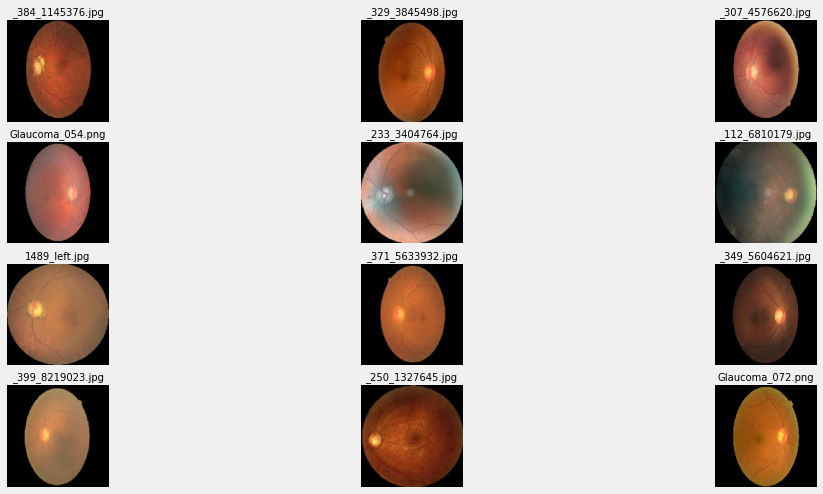

In [10]:
show_images(kind='glaucoma', id=990, random_choice=False, make_subplots=True)

Normal

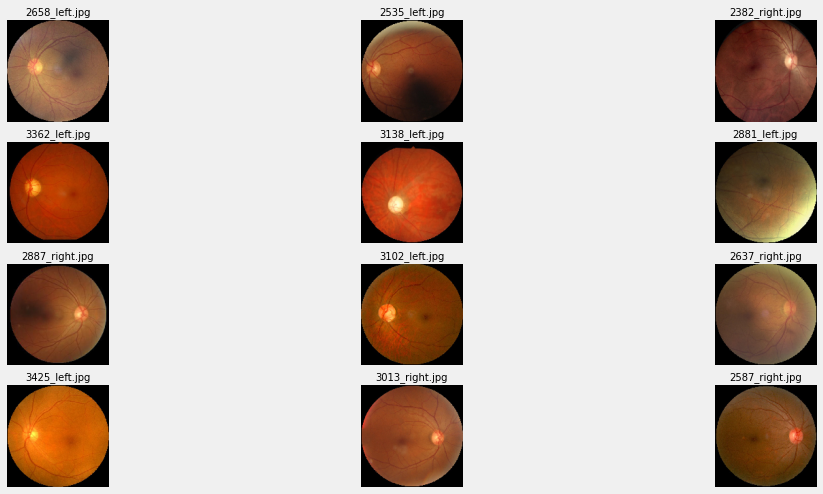

In [11]:
show_images(kind='normal', id=990, random_choice=False, make_subplots=True)

# Creating Dataset with Train and Test Files

In [12]:
cataract_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'cataract'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

diabetic_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'diabetic_retinopathy'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

glaucoma_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'glaucoma'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

normal_filenames = [file for file in os.listdir(path=os.path.join(BASE_DIR, 'normal'))
if file.split('.')[1] in ['jpg', 'jpeg', 'png']]

In [13]:
SIZE = min([len(cataract_filenames), len(diabetic_filenames), len(glaucoma_filenames),
        len(normal_filenames)])

TRAIN_SIZE = int(floor(SIZE * 0.8))
TEST_SIZE = SIZE - TRAIN_SIZE

TRAIN_INDEX = TRAIN_SIZE
TEST_INDEX = SIZE

In [14]:
train_dir = os.path.join(DATASET_DIR, 'train')
test_dir = os.path.join(DATASET_DIR, 'test')

train_cataract_dir = os.path.join(train_dir, 'cataract')
train_diabetic_dir = os.path.join(train_dir, 'diabetic_retinopathy')
train_glaucoma_dir = os.path.join(train_dir, 'glaucoma')
train_normal_dir = os.path.join(train_dir, 'normal')

test_cataract_dir = os.path.join(test_dir, 'cataract')
test_diabetic_dir = os.path.join(test_dir, 'diabetic_retinopathy')
test_glaucoma_dir = os.path.join(test_dir, 'glaucoma')
test_normal_dir = os.path.join(test_dir, 'normal')

In [15]:
directories = [train_dir, test_dir, train_cataract_dir, train_diabetic_dir,
               train_glaucoma_dir, train_normal_dir, test_cataract_dir,
               test_diabetic_dir, test_glaucoma_dir, test_normal_dir]

for dir in directories:
  if not os.path.exists(path=dir):
    os.mkdir(path=dir)

In [27]:
train_cataract_set = [os.path.join(BASE_DIR, 'cataract', file) for
                      file in cataract_filenames[:TRAIN_INDEX]]
train_diabetic_set = [os.path.join(BASE_DIR, 'diabetic_retinopathy', file) for
                      file in diabetic_filenames[:TRAIN_INDEX]]
train_glaucoma_set = [os.path.join(BASE_DIR, 'glaucoma', file) for
                      file in diabetic_filenames[:TRAIN_INDEX]]
train_normal_set = [os.path.join(BASE_DIR, 'normal', file) for
                    file in normal_filenames[:TRAIN_INDEX]]

test_cataract_set = [os.path.join(BASE_DIR, 'cataract', file) for
                     file in cataract_filenames[TRAIN_INDEX:TEST_INDEX]]
test_diabetic_set = [os.path.join(BASE_DIR, 'diabetic_retinopathy', file) for
                     file in diabetic_filenames[TRAIN_INDEX:TEST_INDEX]]
test_glaucoma_set = [os.path.join(BASE_DIR, 'glaucoma', file) for
                     file in glaucoma_filenames[TRAIN_INDEX:TEST_INDEX]]
test_normal_set = [os.path.join(BASE_DIR, 'normal', file) for
                   file in normal_filenames[TRAIN_INDEX:TEST_INDEX]]

In [30]:
print(f'Train Cataract Set Size -> {len(train_cataract_set)}')
print(f'Train Diabetic Set Size -> {len(train_diabetic_set)}')
print(f'Train Glaucoma Set Size -> {len(train_glaucoma_set)}')
print(f'Train Normal Set Size -> {len(train_normal_set)}')

print(f'Test Cataract Set Size -> {len(test_cataract_set)}')
print(f'Test Diabetic Set Size -> {len(test_diabetic_set)}')
print(f'Test Glaucoma Set Size -> {len(test_glaucoma_set)}')
print(f'Test Normal Set Size -> {len(test_normal_set)}')

directories_from_copy = [train_cataract_set, train_diabetic_set,
                         train_glaucoma_set, train_normal_set, test_cataract_set,
                         test_diabetic_set, test_glaucoma_set, test_normal_set]

Train Cataract Set Size -> 805
Train Diabetic Set Size -> 805
Train Glaucoma Set Size -> 805
Train Normal Set Size -> 805
Test Cataract Set Size -> 202
Test Diabetic Set Size -> 202
Test Glaucoma Set Size -> 202
Test Normal Set Size -> 202


In [56]:
def create_sets(directories:List[List[str]]) -> None:
  """
  Copying files from files directory to dataset directory in order to
  creating cataract, diabetic_retinopathy, glaucoma and normal train and test sets.

  Parameters:
  ----------
  directories: list
    List of strings. String must be path to the file.

  Returns:
  -------
  None
  """
  for directory in directories:
    print(directory)

In [57]:
directories_from_copy = [train_cataract_set, train_diabetic_set,
                         train_glaucoma_set, train_normal_set, test_cataract_set,
                         test_diabetic_set, test_glaucoma_set, test_normal_set]

directories_to_copy = [train_cataract_dir, train_diabetic_dir, train_glaucoma_dir,
                       train_normal_dir, test_cataract_dir, test_diabetic_dir,
                       test_glaucoma_dir, test_normal_dir]

create_sets(directories=directories_from_copy)

['/content/files/cataract/_49_7277741.jpg', '/content/files/cataract/cataract_034.png', '/content/files/cataract/_244_5451565.jpg', '/content/files/cataract/2128_right.jpg', '/content/files/cataract/2155_left.jpg', '/content/files/cataract/_247_9509040.jpg', '/content/files/cataract/cataract_069.png', '/content/files/cataract/2184_left.jpg', '/content/files/cataract/_34_2026427.jpg', '/content/files/cataract/2181_left.jpg', '/content/files/cataract/1415_left.jpg', '/content/files/cataract/2127_right.jpg', '/content/files/cataract/cataract_039.png', '/content/files/cataract/2151_right.jpg', '/content/files/cataract/2101_left.jpg', '/content/files/cataract/_388_2242538.jpg', '/content/files/cataract/2228_right.jpg', '/content/files/cataract/_327_3715152.jpg', '/content/files/cataract/_216_7774590.jpg', '/content/files/cataract/_88_1858467.jpg', '/content/files/cataract/cataract_097.png', '/content/files/cataract/_345_8957256.jpg', '/content/files/cataract/_305_9499345.jpg', '/content/fil